In [1]:
import numpy as np #for Linear Algebra (matrices)
import pandas as pd #for reading the data
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv(r'C:\Users\Aravind Kumar\Documents\Programming Projects\Python MNIST Project\train.csv')

In [3]:
#data.head() Shows the preview of the table

In [4]:
data=np.array(data) #converts pandas to numpy
m , n = data.shape #shape of the data, where m is rows (examples), and n is columns (pixels)
np.random.shuffle(data) #shuffle the data alogn the rows to avoid any bias

data_dev= data[0:1000].T #Selects first 1000 samples for dev/validation and transposes it.
Y_dev=data_dev[0] #This is the final output (the numbers 0-9). This is the first column (0th index). 
X_dev=data_dev[1:n] #This is the remaining columns (n=784 pixels).

data_train=data[1000:m].T #This is the training set of the data which is from 1000 to m (here 42000)
Y_train=data_train[0] #Same like validation set, first column is the output labels.
X_train=data_train[1:n] #Same like validation set, this is the remaining columns 


X_train = X_train / 255
X_dev = X_dev / 255

The training data is normalized between 0 and 1 (by dividing by 255). With this normalization:
    - Stabilized Learning: Neural networks learn through gradient descent, and large input values can lead to very large activations and gradients. This leads to exploding/vanishing gradients, and unstable learning.
    - Converge faster: The weights don't have to work as hard to adjust to the wide ranging inputs (instead of 0-255, it's now 0-1)
    - Prevent bias towards highs and ensures each pixel contributes equally. 
    - Works well with softmax and ReLU activation functions as they work best with small input values.

In [5]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.zeros((10,1))
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.zeros((10,1))
    return W1, b1, W2, b2


### Weights are needed per connection, but biases are needed per neuron.
### rand(p,q) generates a random matrix of size p by q.
W1 is weight matrix of the first layer (input to hidden). 10 hidden neurons with 784 weight (one per input pixel). Therefore, 10 rows and 784 columns. The -0.5 is to center the weights around 0, instead of 0-1.
For W2, it is weight matrix of the second layer (hidden to output). 10 output neurons each taking 10 inputs from hidden layer. Therefore, 10 rows and 10 columns. 

b1 and b2 are bias matrices. Only one bias required per neuron therefore it is a 10 by 1, column matrix.


In [6]:
def ReLU(Z):
    return np.maximum(0,Z) #First layer activation function

In [7]:
def softmax(Z):
    Z = Z-np.max(Z,axis=0)
    return np.exp(Z)/np.sum(np.exp(Z),axis =0) #Second layer activation function

In [8]:
def forward_prop(W1,b1,W2,b2,X):
    Z1=W1.dot(X)+b1
    A1=ReLU(Z1)
    Z2=W2.dot(A1)+b2
    A2=softmax(Z2)
    return Z1, A1, Z2, A2

one_hot encoding explination: Consider the row to be indices and the value/label to be column.
First, a 0 matrix of size(Y) and Y.max + 1 is created.

Next, the 1s have to be placed in correct locations.
Example, for Y=[2,0,1], the one-hot encoding should be: 
    Row 0, Column 2 = 1
    Row 1, Column 0 = 1
    Row 2, Column 1 = 1
The resulting matrix becomes: 
    [0, 0, 1]
    [1, 0, 0]
    [0, 1, 0]

Then the transpose is taken so that rows = label and column = example.

In [9]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) #generating a 0 matrix of the size of Y by max of Y + 1
    one_hot_Y[np.arange(Y.size), Y] = 1 #Rows is given by np.arrange(Y.size), and column is given by Y(output)
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

One-hot encoding is a way to represent categorical labels (like digits 0–9) as vectors consisting of 0s and a single 1.
The label is encoded such that only the index corresponding to the label is “hot” (set to 1), while all others are “cold” (set to 0).

For example, if the label is 4, the one-hot encoded vector is: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Each label can be thought of as an axis in a 10-dimensional space, where the axes are all orthogonal (independent). A one-hot vector is like a unit vector pointing in the direction of the correct class.

When a model predicts probabilities (typically using a softmax layer), the output is a probability distribution across all classes.
To evaluate how close this predicted distribution is to the true one-hot label, we use a loss function called cross-entropy loss.

Cross-entropy loss measures how well the predicted probability for the correct class matches 1, and penalizes incorrect predictions more severely. The goal is to minimize this loss so that the model’s predicted probabilities match the true labels more accurately over time.

In [10]:
def deriv_ReLU(Z):
    return Z>0 #When booleans converted to numbers, true = 1 and false is 0. Derivative of ReLU is either 1 or 0

In [11]:
def back_prop(Z1,A1,Z2,A2,W1,W2,X,Y):
    m=Y.size
    one_hot_Y=one_hot(Y)
    dZ2=A2-one_hot_Y #one_hot_Y here is the output
    dW2=1/m * dZ2.dot(A1.T)
    dZ1 = W2.T.dot(dZ2)*deriv_ReLU(Z1)
    dW1=1/m * dZ1.dot(X.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

 Without keepdims and axis, it sums over the entire matrix, producing a scalar, whereas it should be summed column-wise (i.e., over the samples), to get a bias vector.

In [12]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1=W1-alpha*dW1
    b1=b1-alpha*db1
    W2=W2-alpha*dW2
    b2=b2-alpha*db2

    return W1, b1, W2, b2

In [13]:
def get_predictions(A2):
    return np.argmax(A2,0)

In [14]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y)/Y.size

In [15]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [16]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2,W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print("Accuracy: ", get_accuracy(predictions, Y))
            if i%100==0:
                test_prediction(i, W1, b1, W2, b2)
    return W1, b1, W2, b2

Iteration:  0
[5 5 5 ... 5 5 5] [9 7 8 ... 8 5 0]
Accuracy:  0.10409756097560975
Prediction:  [3]
Label:  9


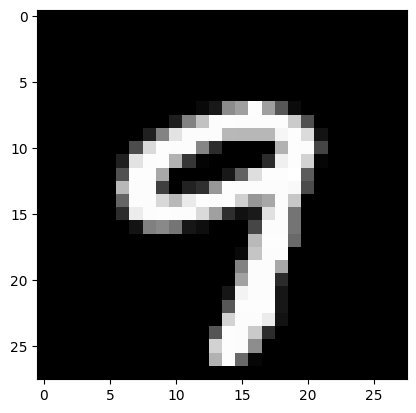

Iteration:  10
[4 7 8 ... 8 0 6] [9 7 8 ... 8 5 0]
Accuracy:  0.6176829268292683
Iteration:  20
[9 9 8 ... 1 0 0] [9 7 8 ... 8 5 0]
Accuracy:  0.572560975609756
Iteration:  30
[9 7 9 ... 1 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.7617073170731707
Iteration:  40
[9 7 8 ... 1 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8376829268292683
Iteration:  50
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8438292682926829
Iteration:  60
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8646341463414634
Iteration:  70
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8818292682926829
Iteration:  80
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8798048780487805
Iteration:  90
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8909756097560976
Iteration:  100
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8959512195121951
Prediction:  [7]
Label:  7


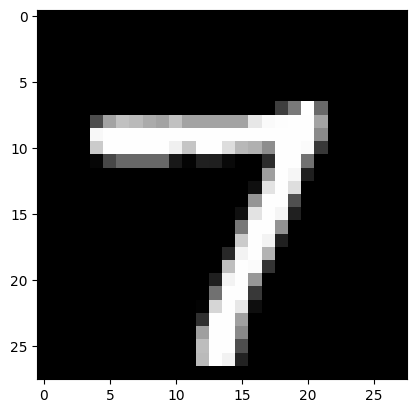

Iteration:  110
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8931219512195122
Iteration:  120
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.8920731707317073
Iteration:  130
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.885609756097561
Iteration:  140
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9093170731707317
Iteration:  150
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.911219512195122
Iteration:  160
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.909609756097561
Iteration:  170
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.903
Iteration:  180
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9133902439024391
Iteration:  190
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9156829268292683
Iteration:  200
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9164146341463415
Prediction:  [4]
Label:  4


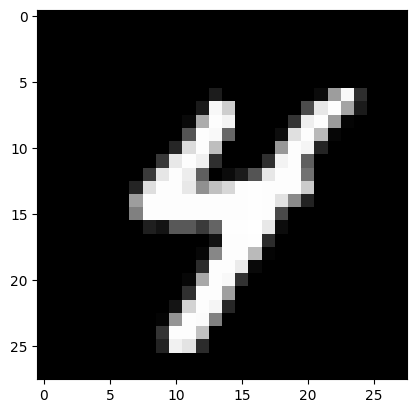

Iteration:  210
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.916219512195122
Iteration:  220
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9113414634146342
Iteration:  230
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9087804878048781
Iteration:  240
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9187317073170732
Iteration:  250
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9201951219512196
Iteration:  260
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9209268292682927
Iteration:  270
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9215853658536586
Iteration:  280
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9211951219512196
Iteration:  290
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9203658536585366
Iteration:  300
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.914
Prediction:  [6]
Label:  6


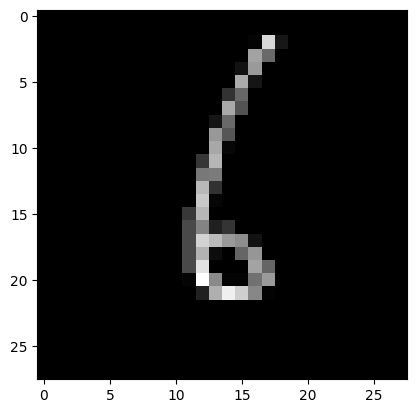

Iteration:  310
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9160243902439025
Iteration:  320
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9241463414634147
Iteration:  330
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9253902439024391
Iteration:  340
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9259268292682927
Iteration:  350
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9263658536585366
Iteration:  360
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9268536585365854
Iteration:  370
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.926609756097561
Iteration:  380
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9237560975609757
Iteration:  390
[9 7 5 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.922219512195122
Iteration:  400
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9273902439024391
Prediction:  [1]
Label:  1


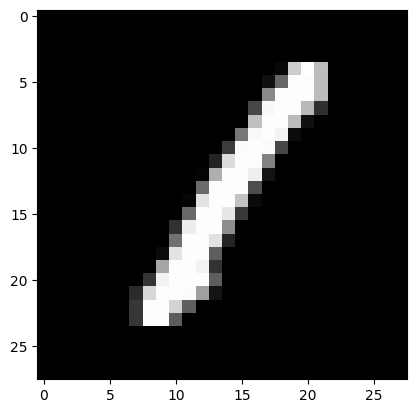

Iteration:  410
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9286829268292683
Iteration:  420
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9292439024390244
Iteration:  430
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9291951219512196
Iteration:  440
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9289756097560976
Iteration:  450
[9 7 4 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9242682926829269
Iteration:  460
[9 7 4 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9084146341463415
Iteration:  470
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9276829268292683
Iteration:  480
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9303414634146342
Iteration:  490
[9 7 8 ... 8 5 0] [9 7 8 ... 8 5 0]
Accuracy:  0.9309756097560976


In [17]:
W1, b1, W2, b2 = gradient_descent(X_train,Y_train, 0.5, 500)